In [1]:
import re
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os
import nltk
from langdetect import detect 
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import pickle
import matplotlib.pyplot as plt


from __future__ import print_function
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM

%matplotlib inline

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
plt.rcParams.update({'font.size': 14})
pd.set_option('display.max_colwidth', 500)

**Practice 6**

# Word2Vec UK

In [3]:
# en_vectors_file = 'word_vectors/numberbatch-en.txt'
uk_vectors_file = 'word_vectors/news.lowercased.tokenized.word2vec.300d'

uk_vectors = KeyedVectors.load_word2vec_format(uk_vectors_file, binary=False)

In [ ]:
# ik_vectors = uk_vectors.get_vector('слово')
# uk_vectors.most_similar('слово', topn=3)

In [4]:
uk_vectors.most_similar(positive=['король', 'жінка'], negative=['чоловік'])[:3]

[('королева', 0.6513357162475586),
 ('принцеса', 0.5810298323631287),
 ('дама', 0.559023916721344)]

In [5]:
morph = pymorphy2.MorphAnalyzer(lang='uk')

In [6]:
def getTextVect(text):
    tokens = nltk.word_tokenize(text)
    lemmas = [(morph.parse(token)[0]).normal_form for token in tokens]
    vectors = np.array([uk_vectors.get_vector(i.lower()) for i in lemmas if i.lower() in uk_vectors.vocab])    
    return np.sum(vectors, axis=0)/len(vectors)

def get_files(directory_path):
    '''Read all files in the given directory to a dataframe'''
    data = []

    for filename in os.listdir(directory_path):
        with open(os.path.join(directory_path, filename)) as f:
            docs = re.split(r'\n{3}', f.read())
            for doc in docs:
                try:
                    language = detect(doc)
                except:
                    language = None
                    continue
                text_id = doc[:8].replace('\n', '')
                if doc.strip('\n') and text_id.isdigit():
                    data.append((text_id, filename[:len(filename)-4], doc[8:], language)) #

    
    df_data = pd.DataFrame(data, columns=['id', 'category', 'text', 'language'])
    df_data = df_data[df_data['language']=='uk']
    df_data = df_data[df_data['text'].map(lambda x: len(x.split())) > 3] 
    # Take categories with more than 50 samples
    cat_sr = df_data['category'].value_counts()
    cat_list = list(cat_sr[cat_sr  >= 50].index)
    df_data = df_data[df_data['category'].isin(cat_list)] 
    
    df_data['docVec'] = df_data['text'].map(getTextVect)
    df_data = df_data[df_data['docVec'].map(lambda x: not(np.isnan(x).any()))].reset_index(drop=True)
      
    return df_data

In [7]:
data_path = 'data/1551/'
df_data = get_files(data_path)

In [8]:
df_data.head()

,id,category,text,language,docVec
0,3096223,Розрахунки--нарахування-та-перерахунок-субсидій,"Хочу Вас спитати, маю я право на субсидію чи ні!\nВ квартирі прописані я та дочка. Батько наш помер у 2014. Він мав інваліда війни 3 групи.Пільги як вдова померлого я оформила. В нас трикімнатна крартира. Кожен місяць рахунки більші за мою пенсію.Дочка навчається. Доходів крім моєї пенсії немає.\n \n\nз повагою, Гончаренко Олена Віталіївна\nконт.273-56-71; 096-118-49-88; 099-143-30-12",uk,"[-1.0909601, -0.116874695, -0.41176084, -0.6168467, 0.05903419, 0.21996725, -0.032099318, -0.0036675013, -0.27422172, -0.4149716, 0.042077873, -1.5608625, 0.037969887, -0.18948591, 1.2568499, 0.31287628, 0.25993744, 0.41402906, 0.13902104, 0.12801929, -0.3351061, -0.5710369, 0.3197645, 0.08948892, -0.79158115, 0.20108879, -0.4329994, -0.016682263, -0.5283405, 0.02291436, 0.40012473, -0.35378963, -0.018278781, 0.008978172, 0.4274974, 0.30007192, 0.3679476, -0.18099965, -0.24835421, 0.40721157..."
1,3354708,Розрахунки--нарахування-та-перерахунок-субсидій,"Питання про надання субсидій. Чому ходять чутки, що при продажі квартири, на яку було оформлено субсидію, з власника квартири буде стягнуто всю суму нарахованої субсидії за весь час отримання субсидії? Чому про це ніде не повідомляється? Прошу надати вичерпну відповідь.",uk,"[-0.989955, 0.1926994, -0.6549754, -0.69367695, -0.22973049, 0.20039703, 0.105874084, -0.14682288, -0.39304075, -0.32372677, 0.13795793, -1.5760422, -0.53672814, -0.36410168, 0.77975285, -0.0048970045, -0.046453618, -0.48741838, -0.053976957, -0.30948785, -0.6815813, -0.40899828, 0.28822252, -0.2757823, -0.41960534, 0.31537753, -0.63145554, -0.26463896, -0.71724147, -0.07192315, 0.96926075, -0.13077907, 0.56775093, 0.46733233, 0.32225585, 0.16244592, -0.04388072, -0.0008768596, -0.19580287, ..."
2,3350015,Розрахунки--нарахування-та-перерахунок-субсидій,"Цього року я подала поштою необхідні документи (заяву, декларацію) для призначення субсидії на послуги ЖКГ до управління соцзахитсу населення Дніпровської РДА м.Києва. На сьогоднішній день відповіді про призначення субсидії чи відмову в призначенні не отримала, незважаючи на те, що передбачені законодавством строки вже давно минули. Зараз мені знову прийшли бланки заяви та декларації для призначення субсидії. Однак, я не знаю - чи надана мені вже субсидія чи ні.",uk,"[-1.0093598, 0.32230285, -0.10971967, -0.64529246, 0.42100358, 0.1571968, 0.19914788, -0.39876357, -0.59269035, -0.56539327, 0.0057127276, -1.4707388, -0.20318426, -0.30612618, 0.7071646, 0.16231872, 0.15698154, -0.32329273, -0.25644627, 0.2602573, -0.33213568, -0.5507435, 0.4942982, -0.2537324, -0.5728912, -0.11887461, -0.89230424, -0.21637717, -0.65805537, 0.034131348, 0.78443456, -0.030089753, 0.53200746, -0.110284686, 0.6034805, 0.2598794, -0.185693, -0.16888574, -0.26421806, 0.6734322, ..."
3,3223482,Розрахунки--нарахування-та-перерахунок-субсидій,"Сьогодні був у відділі супсидій (повинні були автоматично перерахувати). Досі вони не знають коли іі оформлять, але обіцяють до вересня. Квитанціі приходять по 400грн. Що мені з ними робити і хто маєсплачувати піню ???",uk,"[-1.0750777, -0.27748924, -0.586675, -0.7540479, 0.16387095, 0.47098255, 0.2622617, -0.12993161, -0.55929244, -1.0623599, -0.5242726, -2.553788, 0.19242902, -0.59329075, 1.2366024, 0.028148543, 0.7254445, -0.35880366, 0.07149989, -0.2749947, -0.4567566, -0.51454896, 0.6303797, -0.23550262, -0.5590706, 0.06902207, -0.47042003, -0.6323271, -0.53047526, -0.039445315, 1.6033472, 0.20761178, 0.053713005, 0.80484474, 0.3853791, 0.33037925, 0.4020571, -0.26278126, -0.038447775, 0.3728581, -1.144706..."
4,3075714,Розрахунки--нарахування-та-перерахунок-субсидій,Як оформити і куди звертатися для оформлення субсидії?\nЯ не працюю і не стою на обліку в центрі зайнятості.\nДонька навчається на 2 курсі Могилянки.\nВ квартирі прописана лише донька.,uk,"[-1.4578284, -0.23575702, -0.5131072, -0.29448614, -0.017086294, 0.07154574, -0.023625283, 0.048714463, -0.2666531

In [9]:
df_data[df_data['text'].isna()]

,id,category,text,language,docVec


In [10]:
df_data[df_data['id'].str.isdigit()==False].count()

id          0
category    0
text        0
language    0
docVec      0
dtype: int64

**Save the pickle file with prepared data**

In [11]:
with open('ffnn_big_df.pickle', 'wb') as f:
    pickle.dump(df_data[['category', 'text','docVec']], f)


# Feed Forward Neural network

**Small dataset**

In [ ]:
# data_path = 'data/short/1551/'
# df_data = get_files(data_path)

**Big dataset**

In [ ]:
# data_path = 'data/1551/'
# df_data = get_files(data_path)

In [12]:
# Big dataset
with open('ffnn_big_df.pickle', 'rb') as f:
    df_data = pickle.load(f)[['category', 'docVec']]

In [13]:
df_data.head()

,category,docVec
0,Розрахунки--нарахування-та-перерахунок-субсидій,"[-1.0909601, -0.116874695, -0.41176084, -0.6168467, 0.05903419, 0.21996725, -0.032099318, -0.0036675013, -0.27422172, -0.4149716, 0.042077873, -1.5608625, 0.037969887, -0.18948591, 1.2568499, 0.31287628, 0.25993744, 0.41402906, 0.13902104, 0.12801929, -0.3351061, -0.5710369, 0.3197645, 0.08948892, -0.79158115, 0.20108879, -0.4329994, -0.016682263, -0.5283405, 0.02291436, 0.40012473, -0.35378963, -0.018278781, 0.008978172, 0.4274974, 0.30007192, 0.3679476, -0.18099965, -0.24835421, 0.40721157..."
1,Розрахунки--нарахування-та-перерахунок-субсидій,"[-0.989955, 0.1926994, -0.6549754, -0.69367695, -0.22973049, 0.20039703, 0.105874084, -0.14682288, -0.39304075, -0.32372677, 0.13795793, -1.5760422, -0.53672814, -0.36410168, 0.77975285, -0.0048970045, -0.046453618, -0.48741838, -0.053976957, -0.30948785, -0.6815813, -0.40899828, 0.28822252, -0.2757823, -0.41960534, 0.31537753, -0.63145554, -0.26463896, -0.71724147, -0.07192315, 0.96926075, -0.13077907, 0.56775093, 0.46733233, 0.32225585, 0.16244592, -0.04388072, -0.0008768596, -0.19580287, ..."
2,Розрахунки--нарахування-та-перерахунок-субсидій,"[-1.0093598, 0.32230285, -0.10971967, -0.64529246, 0.42100358, 0.1571968, 0.19914788, -0.39876357, -0.59269035, -0.56539327, 0.0057127276, -1.4707388, -0.20318426, -0.30612618, 0.7071646, 0.16231872, 0.15698154, -0.32329273, -0.25644627, 0.2602573, -0.33213568, -0.5507435, 0.4942982, -0.2537324, -0.5728912, -0.11887461, -0.89230424, -0.21637717, -0.65805537, 0.034131348, 0.78443456, -0.030089753, 0.53200746, -0.110284686, 0.6034805, 0.2598794, -0.185693, -0.16888574, -0.26421806, 0.6734322, ..."
3,Розрахунки--нарахування-та-перерахунок-субсидій,"[-1.0750777, -0.27748924, -0.586675, -0.7540479, 0.16387095, 0.47098255, 0.2622617, -0.12993161, -0.55929244, -1.0623599, -0.5242726, -2.553788, 0.19242902, -0.59329075, 1.2366024, 0.028148543, 0.7254445, -0.35880366, 0.07149989, -0.2749947, -0.4567566, -0.51454896, 0.6303797, -0.23550262, -0.5590706, 0.06902207, -0.47042003, -0.6323271, -0.53047526, -0.039445315, 1.6033472, 0.20761178, 0.053713005, 0.80484474, 0.3853791, 0.33037925, 0.4020571, -0.26278126, -0.038447775, 0.3728581, -1.144706..."
4,Розрахунки--нарахування-та-перерахунок-субсидій,"[-1.4578284, -0.23575702, -0.5131072, -0.29448614, -0.017086294, 0.07154574, -0.023625283, 0.048714463, -0.26665318, -0.24543238, -0.42250505, -2.357352, -0.05490648, -0.13519908, 1.2816892, 0.62569046, 0.081969485, -0.07258087, -0.0352072, 0.34922737, -0.18650316, -0.5255508, 0.23716778, -0.08497687, -0.59917164, -0.32372394, -0.48858932, -0.07321261, -0.545889, -0.018029137, 0.78765005, -0.07657756, -0.19291124, -0.023129635, 0.923966, 0.27284634, 0.10240571, -0.29123968, -0.39172223, 0.71..."


In [14]:
df_data['category'].nunique()

186

1) Data

In [15]:
X, y = df_data['docVec'], df_data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_0 =  le.transform(y_train)
y_test_0 =  le.transform(y_test)

In [17]:
x_train_tensor  = torch.FloatTensor(list(X_train))
y_train_tensor = torch.LongTensor(list(y_train_0))
x_test_tensor  = torch.FloatTensor(list(X_test))
y_test_tensor = torch.LongTensor(list(y_test_0))

In [18]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([48608, 300])
torch.Size([48608])


In [19]:
# Hyper-parameters 
input_size = 300
hidden_size = 400
num_classes = pd.Series(y_train_tensor).nunique()
num_epochs = 500
# batch_size = 662 #100
learning_rate = 0.001

## FeedForward Neural Network with Pytorch

In [20]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
        # 20% Dropout here
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
#         out = self.dropout(out)
        # Softmax layer
        out = F.log_softmax(out, dim=1)
        return out

In [21]:
model = NeuralNet(input_size, hidden_size, num_classes)

In [22]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [23]:
# Initialize two empty arrays to hold the train and test losses
train_losses, test_losses = [],[]

train_loss = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train_tensor)

#     print(y_pred.shape)
#     print(y_pred)
#     print(y_train_tensor.shape)
#     print(y_train_tensor)
    # Compute Loss
    loss = criterion(y_pred, y_train_tensor) #y_pred.squeeze(
   
    # Backward pass
    loss.backward()
    optimizer.step()
    train_loss = loss.item()  
    
    # Turn off the gradients
    with torch.no_grad():
        log_ps = model(x_test_tensor)                                 
        ps = torch.exp(log_ps)  
        test_loss = criterion(log_ps, y_test_tensor)
        top_p, top_class = ps.topk(1,dim=1)
        equals = top_class == y_test_tensor.view(*top_class.shape)   
        accuracy = torch.mean(equals.type(torch.FloatTensor))            
    # Append the losses to the array for plotting       
    train_losses.append(train_loss)
    test_losses.append(test_loss)    
    if (epoch%100 == 0):
        print('Epoch {}: train loss: {} test loss: {}'.format(epoch, train_loss, test_loss))

Epoch 0: train loss: 5.219505786895752 test loss: 5.103169918060303
Epoch 100: train loss: 2.2459323406219482 test loss: 2.2678544521331787
Epoch 200: train loss: 1.6656655073165894 test loss: 1.8071155548095703
Epoch 300: train loss: 1.425361156463623 test loss: 1.6730554103851318
Epoch 400: train loss: 1.260006308555603 test loss: 1.6223597526550293


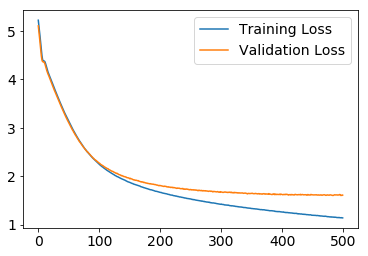

In [24]:
# Plot the graph here
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=True)

## Evaluation on test

In [25]:
outputs = model(x_test_tensor)
_, predicted = torch.max(outputs.data, 1)
total = y_test_tensor.size(0)
correct = (predicted == y_test_tensor).sum().item()
print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 57.71066491112574 %


## LSTM with Keras

## 1. Data

In [3]:
# # 1. UK word2vec
# uk_vectors_file = 'word_vectors/news.lowercased.tokenized.word2vec.300d'
# uk_vectors = KeyedVectors.load_word2vec_format(uk_vectors_file, binary=False)

# # 2. Data
# morph = pymorphy2.MorphAnalyzer(lang='uk')

def getWords2Vect(text):
    tokens = nltk.word_tokenize(text)
    lemmas = [(morph.parse(token)[0]).normal_form for token in tokens]
    
    vectors = np.array([uk_vectors.get_vector(i.lower()) for i in lemmas if i.lower() in uk_vectors.vocab])    
    return vectors

def get_files_for_lstm(directory_path):
    '''Read all files in the given directory to a dataframe'''
    data = []

    for filename in os.listdir(directory_path):
        with open(os.path.join(directory_path, filename)) as f:
            docs = re.split(r'\n{3}', f.read())
            for doc in docs:
                try:
                    language = detect(doc)
                except:
                    language = None
                    continue
                text_id = doc[:8].replace('\n', '')
                if doc.strip('\n') and text_id.isdigit():
                    data.append((text_id, filename[:len(filename)-4], doc[8:], language)) #

    
    df_data = pd.DataFrame(data, columns=['id', 'category', 'text', 'language'])
    df_data = df_data[df_data['language']=='uk']
    df_data = df_data[df_data['text'].map(lambda x: len(x.split())) > 3] 
    # Take categories with more than 50 samples
    cat_sr = df_data['category'].value_counts()
    cat_list = list(cat_sr[cat_sr  >= 50].index)
    df_data = df_data[df_data['category'].isin(cat_list)] 
    
    df_data['words2vec'] = df_data['text'].map(getWords2Vect)
    df_data = df_data[df_data['words2vec'].map(lambda x: not(np.isnan(x).any()))].reset_index(drop=True)
      
    return df_data

**Big dataset**

In [ ]:
# data_path = 'data/1551/'
# df_data = get_files_for_lstm(data_path)

In [ ]:
# with open('lstm_big_df.pickle', 'wb') as f:
#     pickle.dump(df_data[['category', 'words2vec']], f)

In [4]:
with open('lstm_big_df.pickle', 'rb') as f:
    df_data = pickle.load(f)[['category', 'words2vec']]

In [5]:
# Take categories with more than 50 samples
cat_sr = df_data['category'].value_counts()
cat_list = list(cat_sr[cat_sr  >= 300].index)
df_data = df_data[df_data['category'].isin(cat_list)] 

In [65]:
# df_data['category'].value_counts()

In [6]:
OUTPUT_DIM = df_data['category'].nunique()
EMBEDDING_DIM = 300
MAX_SENT_LEN = df_data['words2vec'].map(lambda x: len(x)).max()
MAX_SENT_LEN

365

In [7]:
OUTPUT_DIM

44

In [8]:
le = preprocessing.LabelEncoder()

In [9]:
def get_train_test(df_data, x_column='words2vec', y_column='category'):
    
    #Input zero vectors to have sentence sequences with the same length
    X, y = df_data[x_column], df_data[y_column]
    X = pad_sequences(
                        X,
                        maxlen=MAX_SENT_LEN,
                        dtype='float',
                        padding='post',
                        truncating='post',
                        value=0.0
                    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # LabelEncoder
    le.fit(y_train)
    y_train =  to_categorical(le.transform(y_train))
    y_test =  to_categorical(le.transform(y_test))
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = get_train_test(df_data, x_column='words2vec', y_column='category')

## 2. LSTM architecture

In [11]:
X_train.shape

(33938, 365, 300)

In [15]:
LSTM_OUT = 200#3

model = Sequential()

model.add(LSTM(units = LSTM_OUT, input_shape=(MAX_SENT_LEN, 300) ))#)) # ( number of time steps, number of input units)
model.add(Dense(OUTPUT_DIM, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_2 (Dense)              (None, 44)                8844      
Total params: 409,644
Trainable params: 409,644
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
BATCH_SIZE = 300

In [17]:
history = model.fit(X_train, y_train,\
          batch_size= BATCH_SIZE,
          epochs = 10,
          validation_split=0.33,          
          verbose = 1)



Instructions for updating:
Use tf.cast instead.
Train on 22738 samples, validate on 11200 samples
Epoch 1/10
22738/22738 [==============================] - 312s 14ms/step - loss: 3.5017 - acc: 0.1237 - val_loss: 3.4278 - val_acc: 0.1434
Epoch 2/10
22738/22738 [==============================] - 324s 14ms/step - loss: 3.4106 - acc: 0.1509 - val_loss: 3.4299 - val_acc: 0.1434
Epoch 3/10
22738/22738 [==============================] - 342s 15ms/step - loss: 3.4101 - acc: 0.1509 - val_loss: 3.4279 - val_acc: 0.1434
Epoch 4/10
22738/22738 [==============================] - 342s 15ms/step - loss: 3.4106 - acc: 0.1509 - val_loss: 3.4272 - val_acc: 0.1434
Epoch 5/10
22738/22738 [==============================] - 334s 15ms/step - loss: 3.4103 - acc: 0.1509 - val_loss: 3.4269 - val_acc: 0.1434
Epoch 6/10
22738/22738 [==============================] - 325s 14ms/step - loss: 3.4100 - acc: 0.1509 - val_loss: 3.4285 - val_acc: 0.1434
Epoch 7/10
22738/22738 [==============================] - 324s 14ms/

In [18]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("{}: {}\n{}: {}".format(model.metrics_names[1], scores[1]*100, model.metrics_names[0], scores[0]))

acc: 14.342958161461402
loss: 3.4249755964464628


**Plot Keras History**

Plot loss and accuracy for the training and validation set.

In [20]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

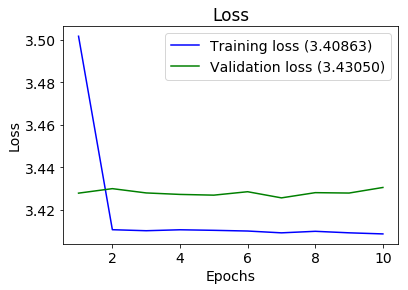

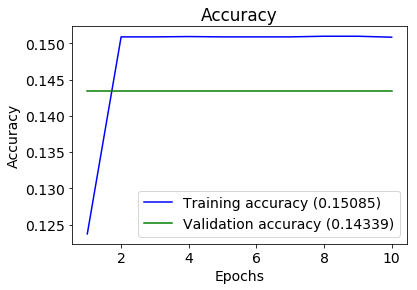

In [21]:
plot_history(history)